<a href="https://colab.research.google.com/github/samyarsworld/Human-segmentation-deep-learning/blob/main/Human_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Human Segmentation

### 1. Install Segmentation Library and Change Runtime:
* Change the Colab runtime to support the latest available GPU (T4 at this time)
* Install segmentation models. Refer to https://smp.readthedocs.io/en/latest/ for documentation. In this project "Unet" segmentation model and "timm-efficientnet-b0" encoder with "imagenet" weights is implemented.


In [ ]:
!pip install -U segmentation-models-pytorch

**segmentation-models-pytorch:** Offers a collection of pre-trained models and various segmentation architectures that you can use for your own image segmentation projects. These models are often based on state-of-the-art deep learning architectures and can be fine-tuned for specific tasks or used as feature extractors.

### 2. Download the dataset and helper functions:

Repository address: https://github.com/samyarsworld/Human-segmentation-deep-learning

The directory includes the two sub-directories of segmented images and their corresponding images, a helper functions file, and a CSV file containing training data information.
Move to the directory.

In [ ]:
!git clone https://github.com/samyarsworld/Human-segmentation-deep-learning
%cd Human-segmentation-deep-learning

### 3. Import Required Libraries and Functions:

In [61]:
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from tqdm import tqdm
from PIL import Image
import random

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

from helper_functions import plot_transformed_images, plot_images

### 4. Setup Initial Configurations:

In [63]:
# Configure device agnostic model (preferably on GPU)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Setup path to data folder
data_path = Path("data/")

# Setup train and segmented paths
train_dir = data_path / "training_dataset"
segmented_dir = data_path / "segmented_dataset"

# Get all image paths (* means "any combination")
train_image_path_list = sorted(list(train_dir.glob("*.jpg")))
segmented_image_path_list = sorted(list(segmented_dir.glob("*.png")))

Check out how image and its corresponding segmentation look like:

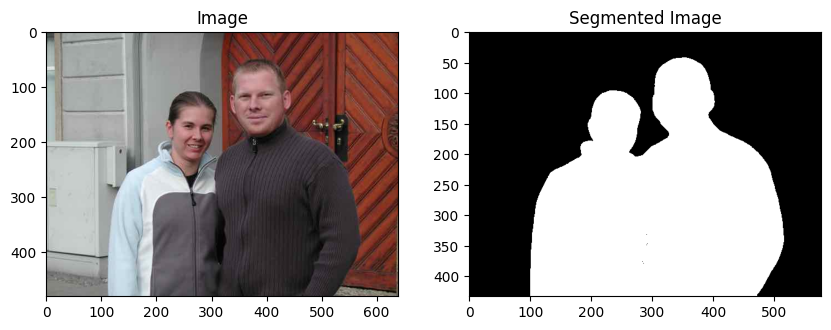

In [10]:
# Get a random image index
random_index = random.randint(0, len(train_image_path_list) - 1)

# Build a to tensor transform function
to_tensor = transforms.ToTensor()

# Transform the base image and segmented image to tensor
test_image = to_tensor(Image.open(train_image_path_list[random_index]))
test_segmented_image = to_tensor(Image.open(segmented_image_path_list[random_index]))

plot_images(test_image, test_segmented_image)

### 5. Setup Transformation

In [36]:
# Set image transform size
IMAGE_SIZE = 320

# Transform train data function
train_data_transform = transforms.Compose([
    # Resize the images
    transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0), # p = probability of flip
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

# Transform test data
test_data_transform = transforms.Compose([
    transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
])

Check out how the transformation is changing the images:

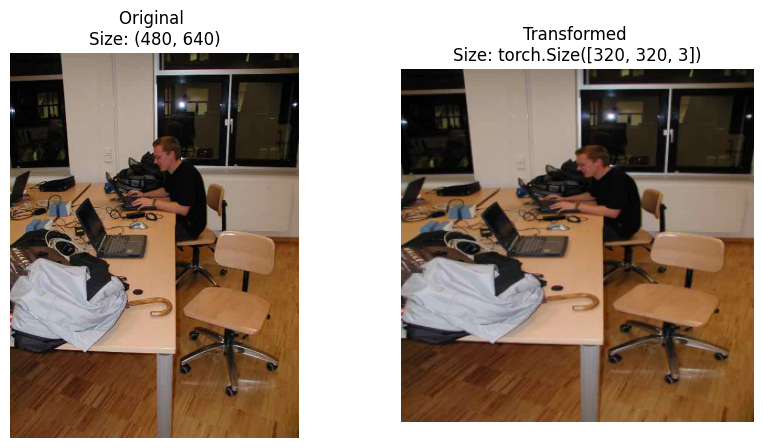

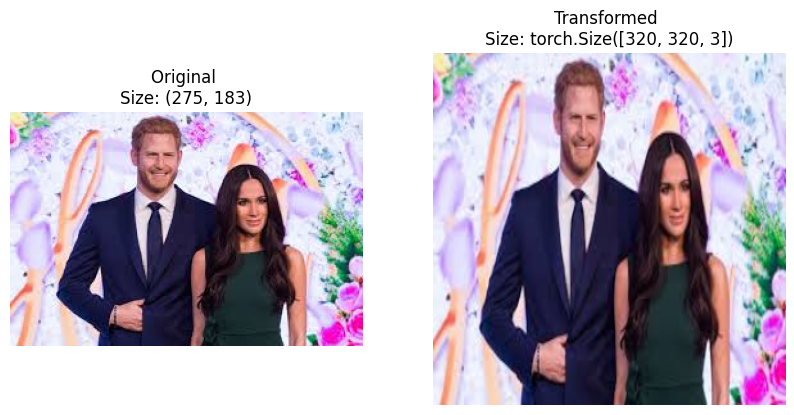

In [6]:
plot_transformed_images(train_image_path_list, data_transform, n=2)

### 6. Create Custom Dataset

In [46]:
class ImageFolderCustom(Dataset):
  def __init__(self, base_dir: str, target_dir: str, train, transform=None, train_size=0.7) -> None:
    all_base_images = sorted(list(Path(base_dir).glob("*.jpg")))
    all_target_images = sorted(list(Path(target_dir).glob("*.png")))
    ind = round(len(all_base_images) * train_size)

    if train:
      self.data = all_base_images[:ind]
      self.targets = all_target_images[:ind]
    else:
      self.data = all_base_images[ind:]
      self.targets = all_target_images[ind:]


    self.transform = transform

  def load_image(self, index: int) -> Image.Image:
    image_path = self.data[index]
    target_path = self.targets[index]
    return Image.open(image_path), Image.open(target_path)

  def __len__(self) -> int:
    return len(self.data)

  def __getitem__(self, index: int) -> torch.Tensor:
    img, target = self.load_image(index)

    # Transform if exists
    if self.transform:
        return self.transform(img), self.transform(target)
    else:
        return img, target

In [47]:
train_dataset = ImageFolderCustom(base_dir=train_dir, target_dir=segmented_dir, train=True, train_size=0.7, transform=train_data_transform)
test_dataset = ImageFolderCustom(base_dir=train_dir, target_dir=segmented_dir, train=False, train_size=0.7,transform=test_data_transform)

In [48]:
img, target = test_dataset[0]

### 7. Batch the Dataset

In [52]:
BATCH_SIZE = 16

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### 8. Create The Segmentation Model

In [66]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

ENCODER = "timm-efficientnet-b0" # From segmentation-models-pytorch project
WEIGHTS = "imagenet"

# Loss functions
dice_loss = DiceLoss(mode="binary")
BCE_loss = nn.BCEWithLogitsLoss()

class SegmentationModel(nn.Module):
  def __init__(self):
    super().__init__()

    self.layers = smp.Unet(
        encoder_name=ENCODER,
        encoder_weights=WEIGHTS,
        in_channels=3,
        classes=1,
        activation=None
    )

  def forward(self, images):
    logits = self.layers(images)

    return logits

In [67]:
model = SegmentationModel().to(DEVICE)

### 9. Create Train and Validation Function

In [68]:
### Training Setup

def train(data_loader, model, optimizer):
  tot_loss = 0.0

  # Set the enviornment to train
  model.train()

  # Loop through batches (with progress bar)
  for images, targets in tqdm(data_loader):
    images = images.to(DEVICE)
    targets = targets.to(DEVICE)

    # Calculate the predictions (logits)
    logits = model(images)

    # Calculate the loss
    loss1 = dice_loss(logits, targets)
    loss2 = BCE_loss(logits, targets)
    loss = loss1 + loss2

    # Set grads to zero
    optimizer.zero_grad()

    # Perform back propagation
    loss.backward()

    # Update weights and biases using ADAM
    optimizer.step()

    # Add batch loss to total loss
    tot_loss += loss.item()

  return tot_loss / (len(data_loader))

In [69]:
### Testing Setup

def test(data_loader, model):
  tot_loss = 0.0

  # Set the enviornment to evaluation/inference mode
  model.eval()

  with torch.inference_mode():
    # Loop through batches (with progress bar)
    for images, targets in tqdm(data_loader):
      images = images.to(DEVICE)
      targets = targets.to(DEVICE)

      # Calculate the predictions (logits)
      logits = model(images)

      # Calculate the loss
      loss1 = dice_loss(logits, targets)
      loss2 = BCE_loss(logits, targets)
      loss = loss1 + loss2

      # Add batch loss to total loss
      tot_loss += loss.item()

  return tot_loss / (len(data_loader))

### 10. Train Model

In [ ]:
EPOCHS = 50
LR = 0.01

optimizer = torch.optim.Adam(params=model.parameters(), lr = LR)
best_test_loss = np.Inf

for epoch in range(EPOCHS):
  train_loss = train(train_loader, model, optimizer=optimizer)
  test_loss = train(test_loader, model)

  if test_loss < best_test_loss:
    best_test_loss = test_loss
    torch.save(model.state_dict(), "model.pt")
    print("Model updated!")

  print(f"Iteration: {epoch}, Training loss: {train_loss}, Testing loss: {test_loss}")


### 11. Inference and Predictions

In [ ]:
model.load_state_dict(torch.load("content/model.pt"))

image, target = test_dataset

logits = model(image.to(DEVICE).unsqueeze(0)) # Unsqueeze to add the batch dimension (here would be just 1)
pred = torch.sigmoid(logits)
pred = (pred > 0.5)

In [ ]:
plot_images(image, target, pred.detach().cpu().squeeze(0))